# Taller 1 - Universidad de los Andes

**Participantes:**

- Erich Giusseppe Soto Parada 
- Nombre 2  
- Nombre 3  


instalaciones 

In [ ]:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128 # Este no es un comando general, depende de tu version de cuda, por ende consulta https://pytorch.org/get-started/locally/ y en linux corre nvidia-smi para ver tu version de cuda

In [ ]:
# pip install pandas scikit-learn seaborn

### imports

In [115]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.nn.functional import one_hot
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, accuracy_score
%matplotlib inline

### Carga de los datos

In [147]:
data_mpg = (
    "/home/erich/dev/mastering_machine_learning/taller_clase_2/Erich/data/auto-mpg.data"
)

In [148]:
df = pd.read_csv(
    data_mpg,
    names=[
        "MPG",
        "Cylinders",
        "Displacement",
        "Horsepower",
        "Weight",
        "Acceleration",
        "Model Year",
        "Origin",
    ],
    sep=" ",
    na_values="?",
    comment="\t",
    skipinitialspace=True,
)

### Exploracion

In [4]:
profile = ProfileReport(
    df,
    title="Reporte de Perfilado",
    explorative=True,
    correlations={
        "auto": {"calculate": False},
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    },
)

In [5]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 82850.45it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Podemos ver en el reporte que muchas de las variables estan altamente coorelacionadas pero dado que solo vamos a usar una no nos genera mayor problema.

Tambien centrandonos en por ejemplo los cilinders, estos tienen una clases con 3 y 5 que son muy inferiores en representatividad a nivel de clases comparados con el resto, por ende el modelo realmente no va a aprender de estas clases se recomienda o aniadirlas a otras de las clases cercanas o eliminar estos datos, aunque al ser ordinal no presenta un problema tan grabe. 

Ademas como esta no va a ser la variable que se va a utilizar pues no se haran los cambios respectivos.

In [150]:
df.head()

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   Model Year  Origin  
0          70       1  
1          70       1  
2          70       1  
3          70       1  
4          70       1

In [151]:
print(f"Shape:  \n{df.shape}\n")
print(f"Numero de nulos: \n{df.isna().sum()}")

Shape:  
(398, 8)

Numero de nulos: 
MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


In [152]:
df = df.dropna()
df = df.reset_index(drop=True)
print(f"Shape:  \n{df.shape}\n")
print(f"Numero de nulos: \n{df.isna().sum()}")

Shape:  
(392, 8)

Numero de nulos: 
MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


### Exploracion de los datos 

In [153]:
df.describe()

MPG   Cylinders  Displacement  Horsepower       Weight  \
count  392.000000  392.000000    392.000000  392.000000   392.000000   
mean    23.445918    5.471939    194.411990  104.469388  2977.584184   
std      7.805007    1.705783    104.644004   38.491160   849.402560   
min      9.000000    3.000000     68.000000   46.000000  1613.000000   
25%     17.000000    4.000000    105.000000   75.000000  2225.250000   
50%     22.750000    4.000000    151.000000   93.500000  2803.500000   
75%     29.000000    8.000000    275.750000  126.000000  3614.750000   
max     46.600000    8.000000    455.000000  230.000000  5140.000000   

       Acceleration  Model Year      Origin  
count    392.000000  392.000000  392.000000  
mean      15.541327   75.979592    1.576531  
std        2.758864    3.683737    0.805518  
min        8.000000   70.000000    1.000000  
25%       13.775000   73.000000    1.000000  
50%       15.500000   76.000000    1.000000  
75%       17.025000   79.000000    2.000000  
max       24.800000   82.000000    3.000000

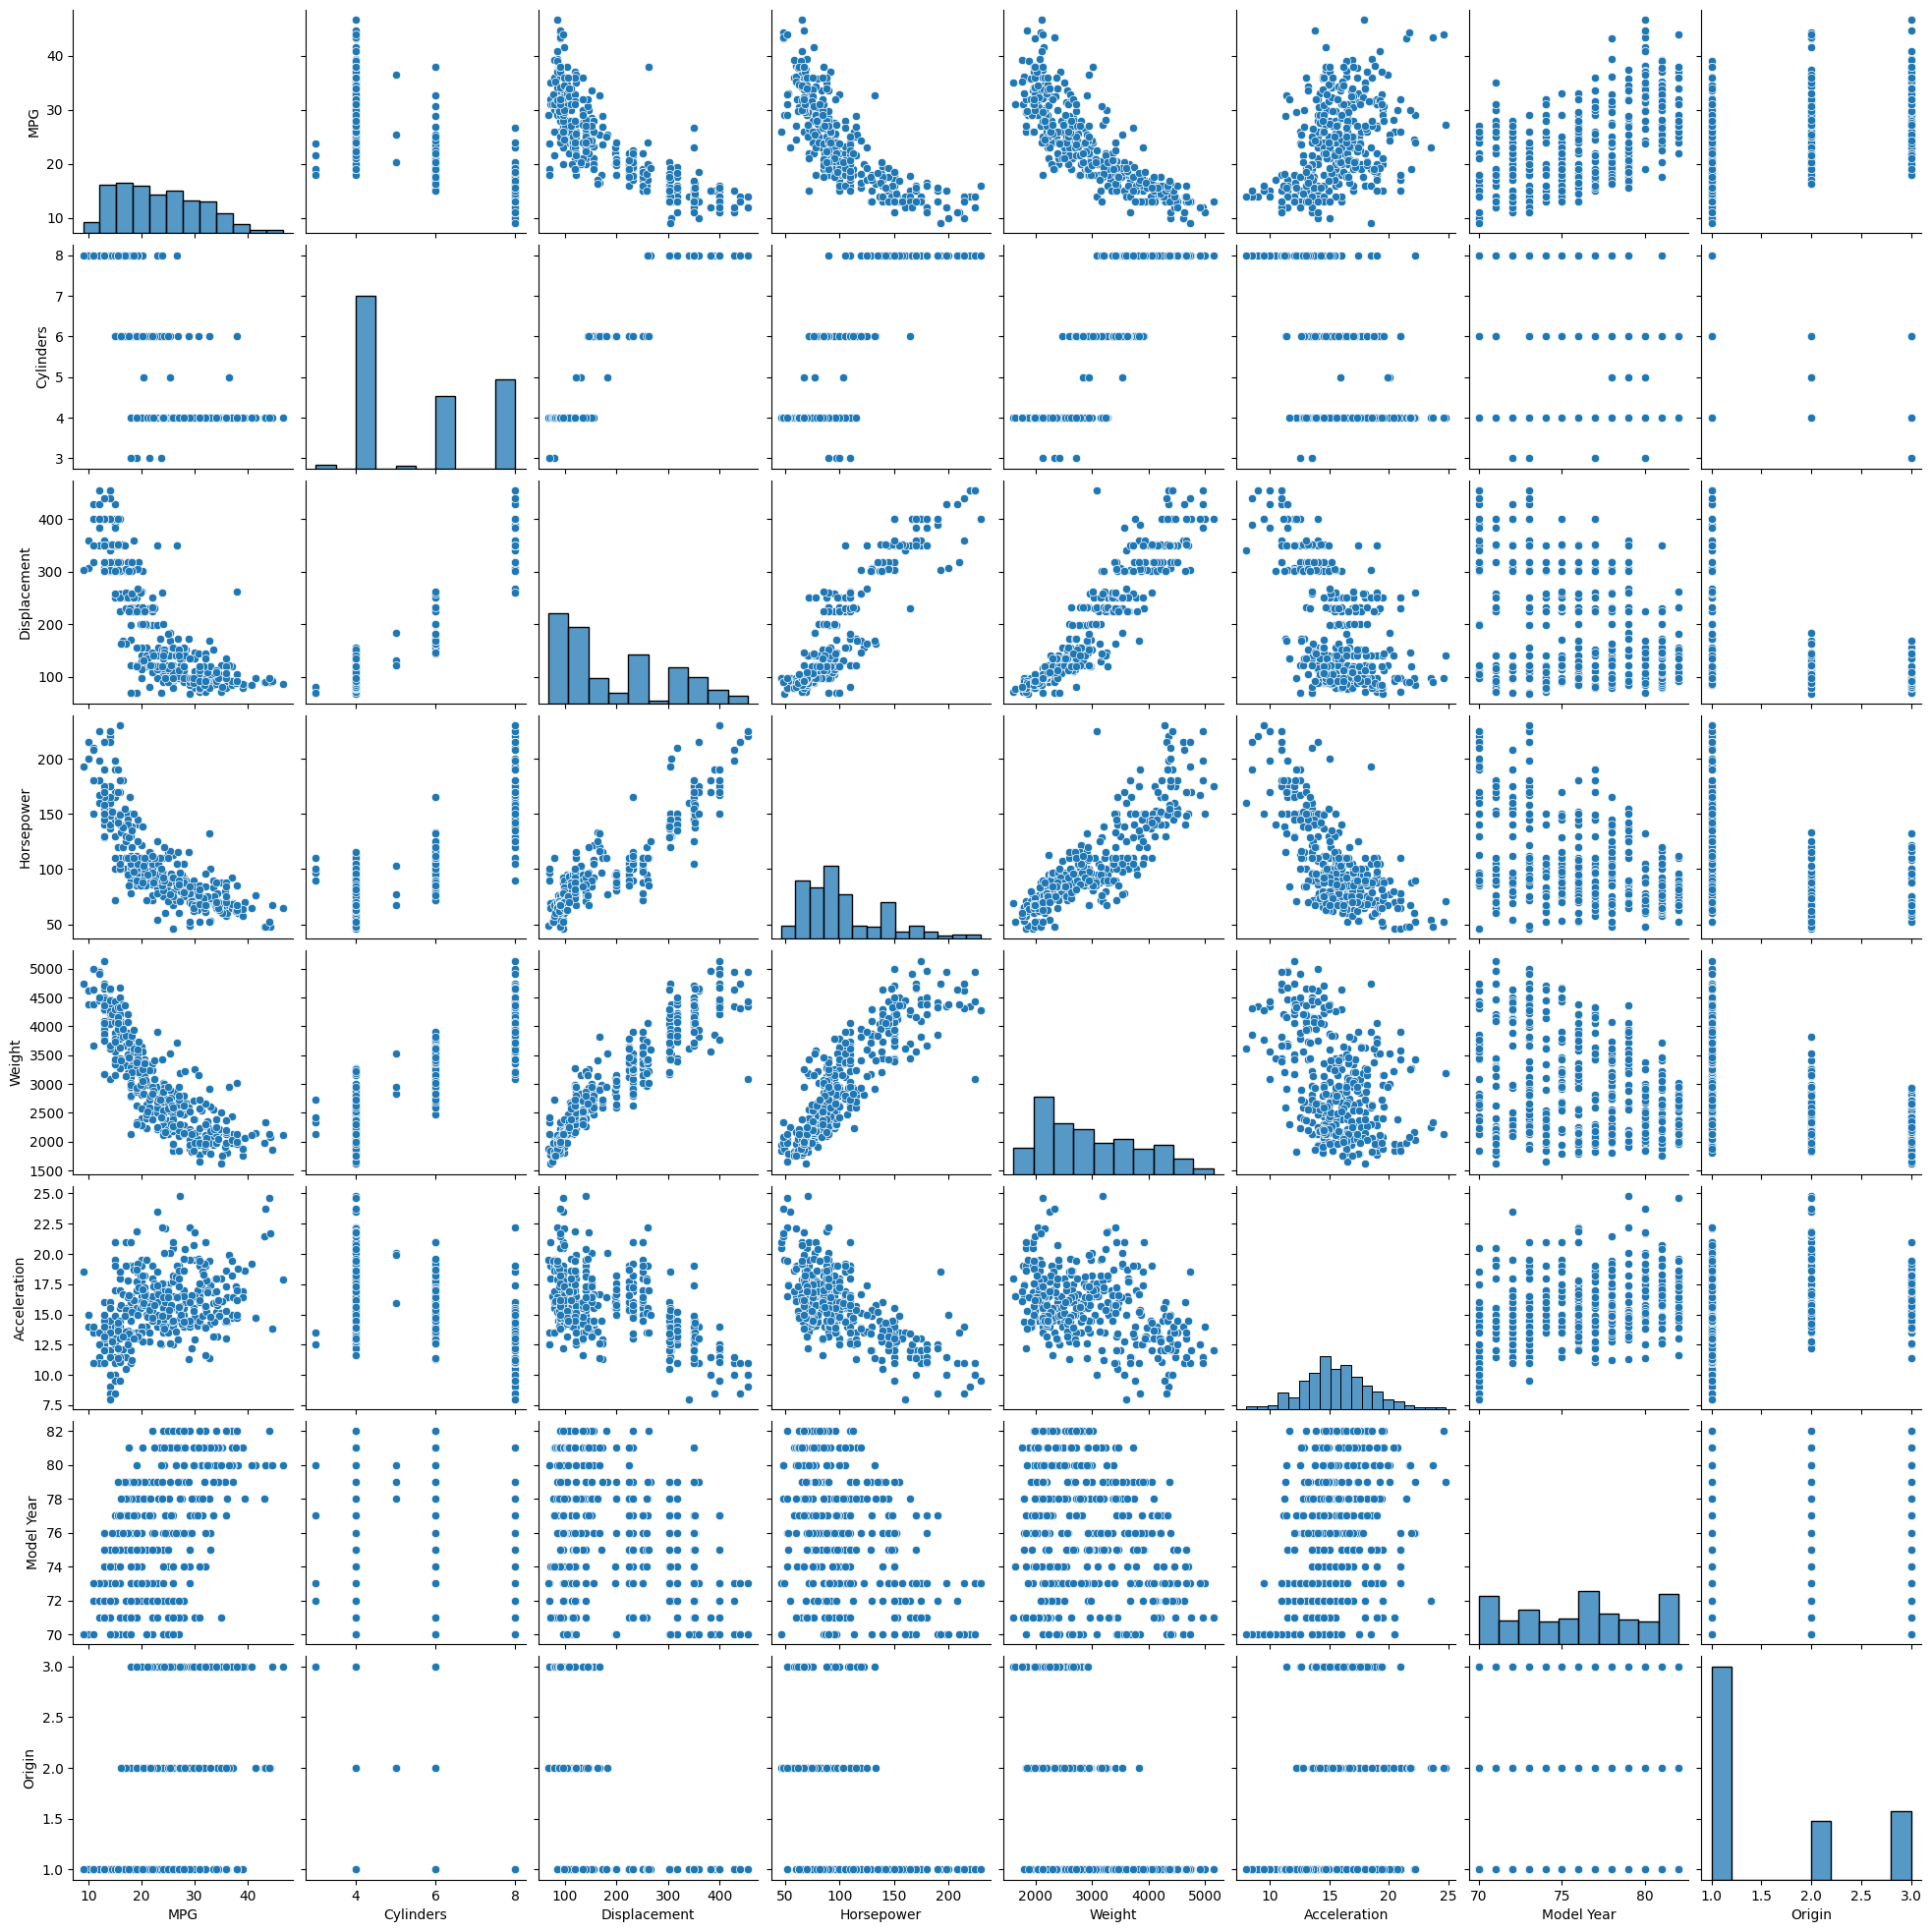

In [154]:
sns.pairplot(df)

Pareciera que muchas de las relaciones por ejemplo tiene mpg aunque pueden ser aproximadas mediante una funcion mas parecida a una exponencial negativa, esto teniendo en cuenta que solo se pueden usar capas lineales tendremos que intentar linealizar los datos del modelos lo mas posible para que el modelo dadas sus capacidades pueda hacer correctamente las predicciones, esto dado que nuestro modelo solo puede aprender relaciones lineales y el modelo de redes neuronales en este caso al no tener funcion de activacion son combinaciones lineales.

In [155]:
df.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin'],
      dtype='object')

In [156]:
# Se hace la prueba para visualizar si los cambios son los correctos se puede intentar usar boxcox
# para algo digamos automatizado pero dado el comportamiento se propone utilizar logaritmica dado que el comportamiento que se ve es exponencial.
columnas_transformacion = ["Displacement", "Horsepower", "Weight"]
df_try = df.copy()

for columna in columnas_transformacion:
    new_column = f"log_{columna}"
    df_try[new_column] = np.log(df_try[columna])
    df_try = df_try.drop(columns=columna)

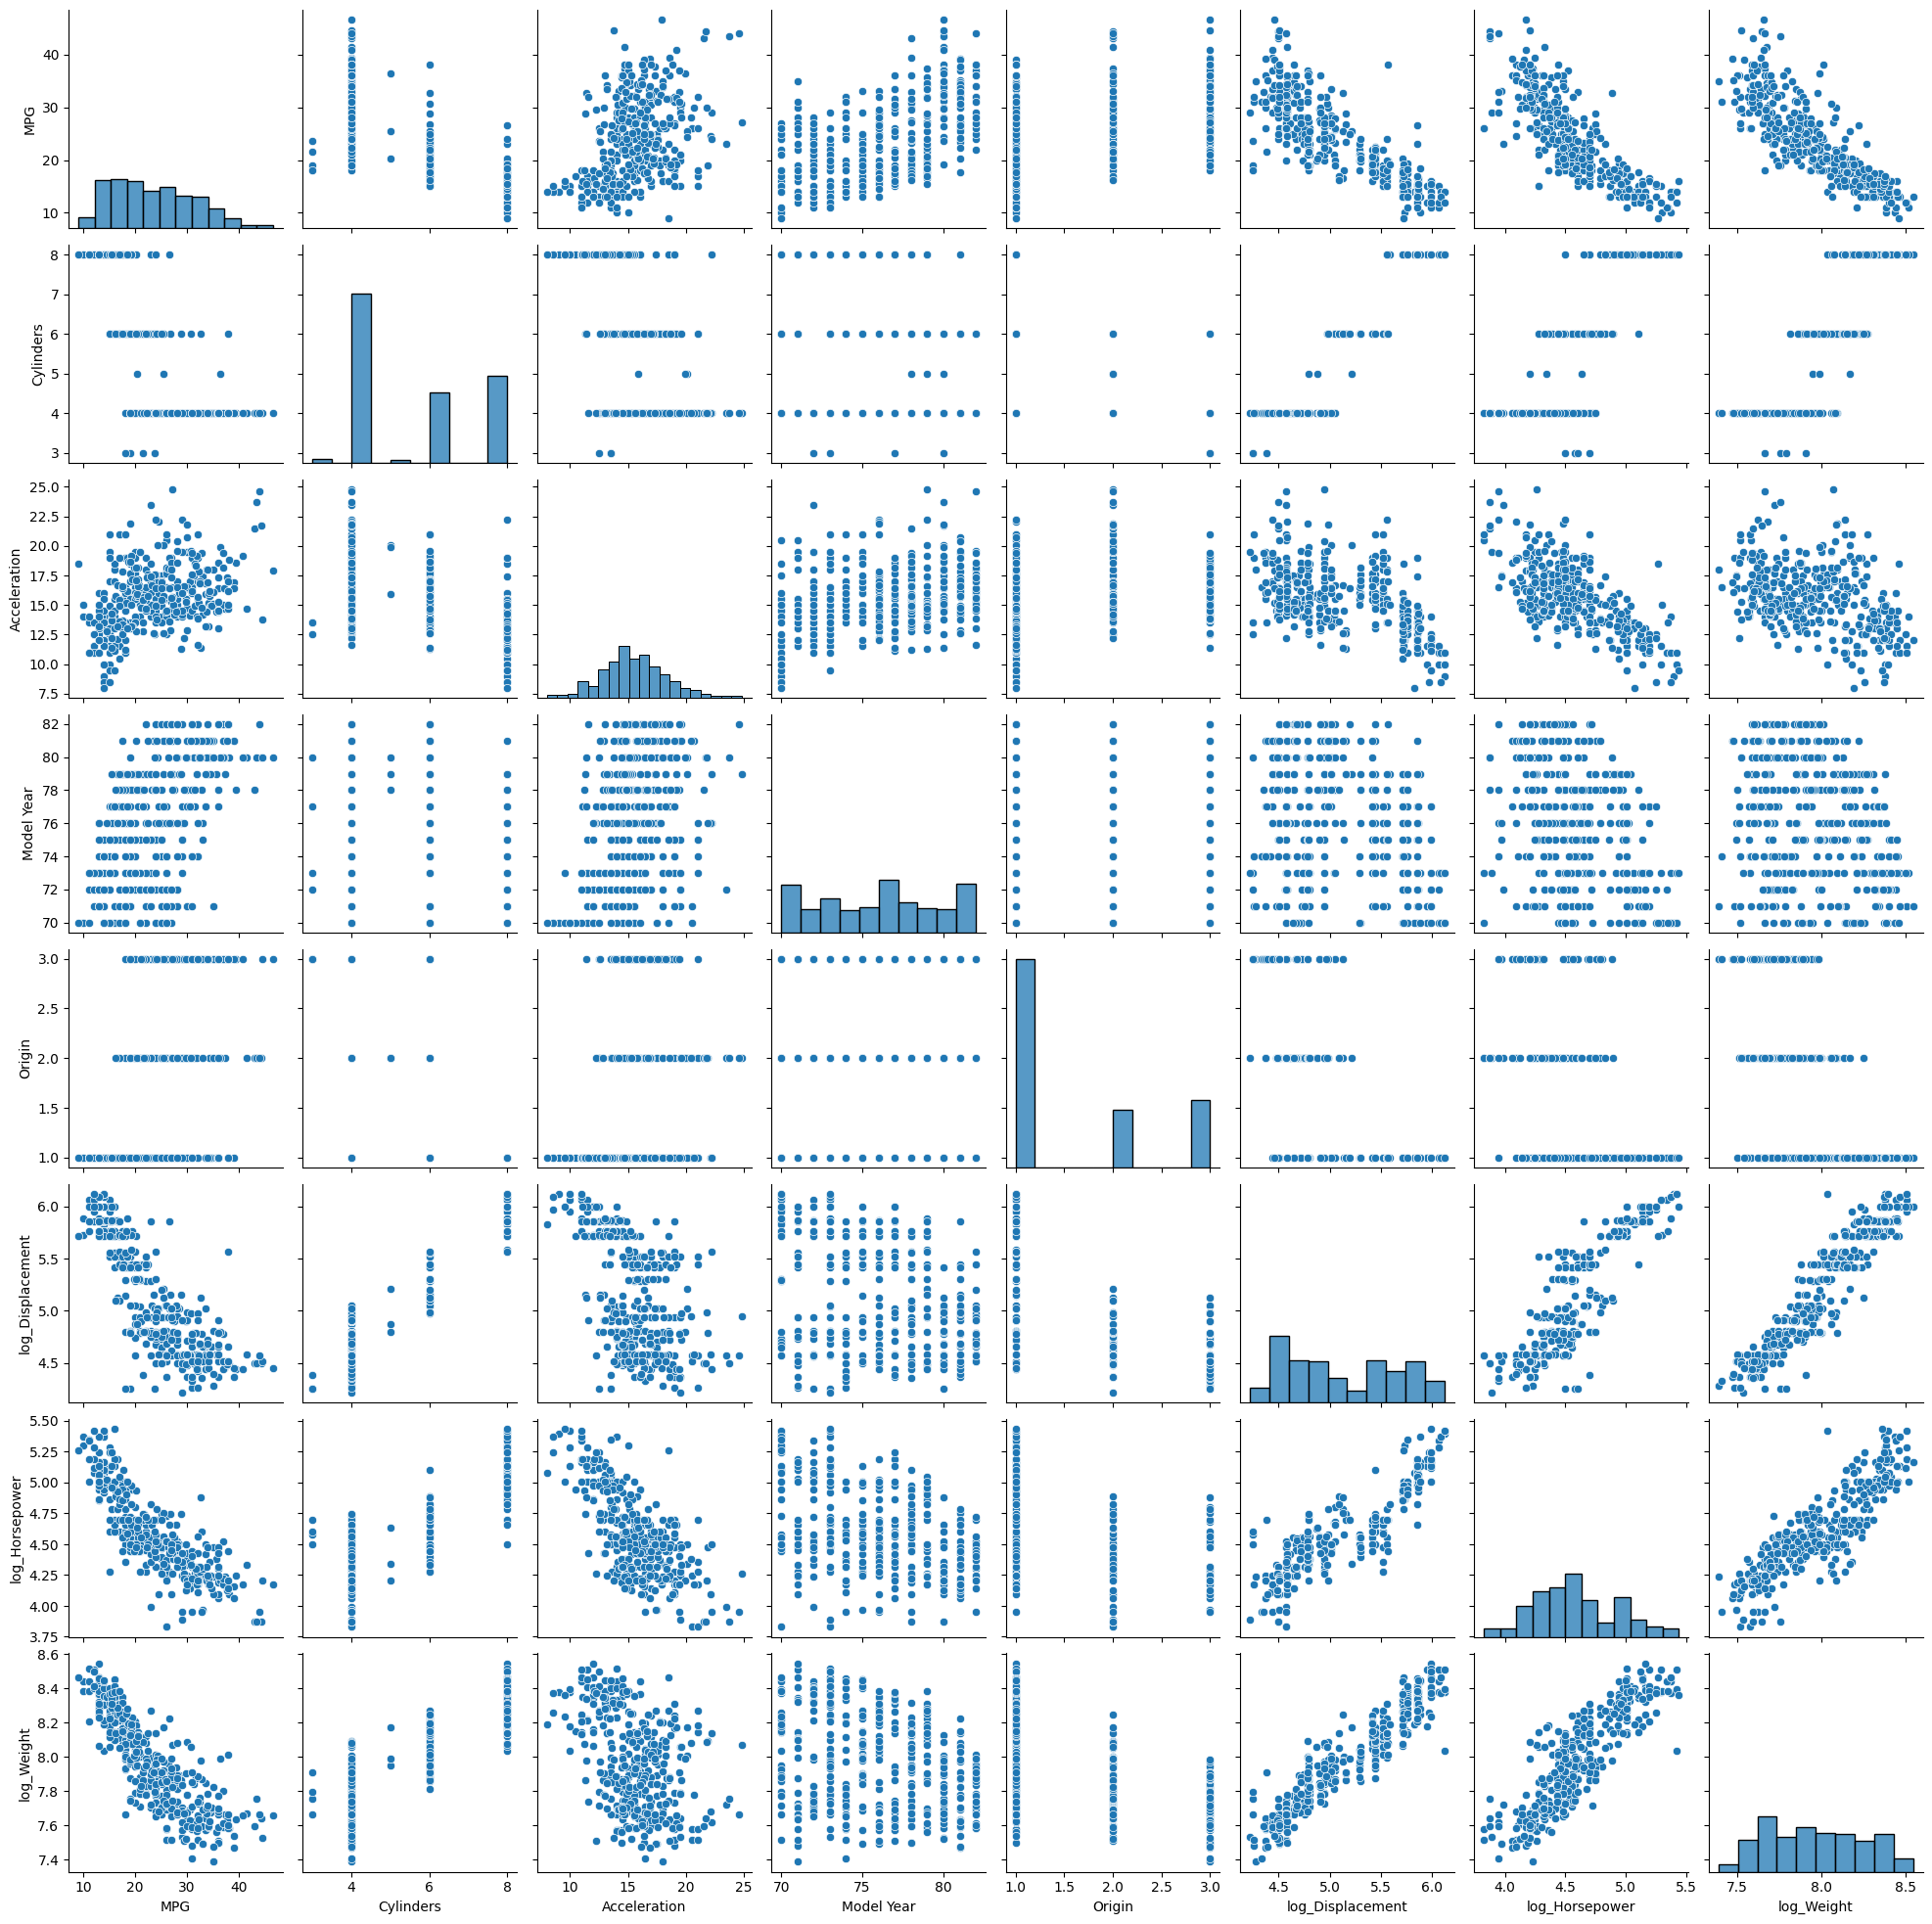

In [157]:
sns.pairplot(df_try)

Ahora para comprobar que las transformaciones funcionaron o son mejores se pueden ver los resultados al implementar modelos o en su defecto podemos ver las correlaciones lineales que nos da pearson para ver que tanto mejoramos o no estas relaciones.

<Axes: >

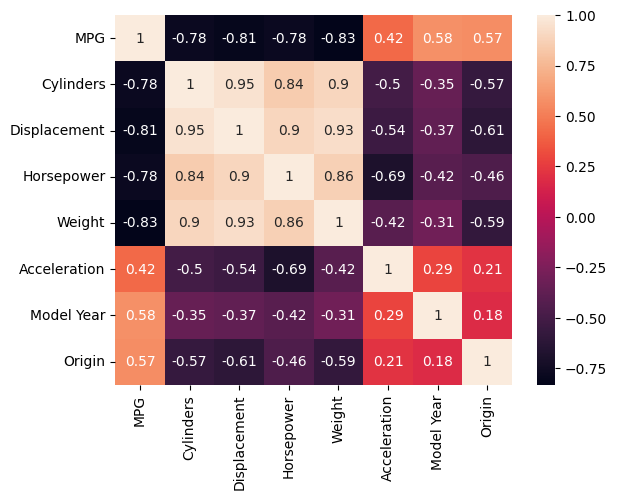

In [158]:
sns.heatmap(df.corr(), annot=True)

<Axes: >

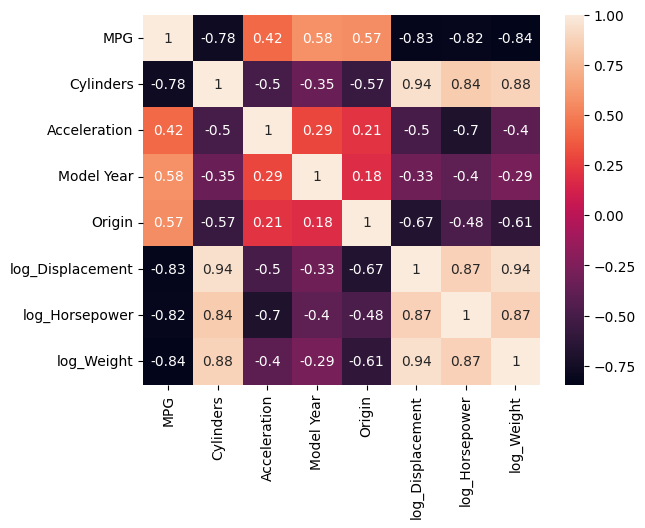

In [159]:
sns.heatmap(df_try.corr(), annot=True)

vemos que si mejora un poco las coorelaciones lineales, por ende dejaremos las variables transformadas con logaritmos

# Parte 1 

Dadas las correlaciones la que tiene mayor coorelacion es la de log_weight por ende va a ser la que se va a utilizar, por ende partiremos los datos en X y Y.

In [161]:
df_try.columns

Index(['MPG', 'Cylinders', 'Acceleration', 'Model Year', 'Origin',
       'log_Displacement', 'log_Horsepower', 'log_Weight'],
      dtype='object')

In [17]:
# X = df[["Weight"]]
# Y = df[["MPG"]]

In [162]:
X = df_try[["log_Weight"]]
Y = df_try[["MPG"]]

particion de los datos en train y test

In [163]:
from sklearn.preprocessing import StandardScaler

In [164]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=100
)  # 77
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
# x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_train.columns, index=x_train.index)
x_train_scaled = torch.tensor(x_train_scaled).float()  # ['log_Weight'].values

x_test_scaled = scaler.transform(x_test)
# x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_test.columns, index=x_test.index)
x_test_scaled = torch.tensor(x_test_scaled).float()  # ['log_Weight'].values

y_train_tensor = torch.tensor(y_train["MPG"].values).float()
y_test_tensor = torch.tensor(y_test["MPG"].values).float()

### Punto 1 y Punto 2

In [165]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

train_ds = TensorDataset(x_train_scaled, y_train_tensor)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [166]:
import torch.nn as nn

hidden_units = [1]
input_size = x_train.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    # all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

# all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)

In [167]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

torch.manual_seed(1)
num_epochs = 1000
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")

Epoch 0 Loss 455.3168
Epoch 20 Loss 18.6469
Epoch 40 Loss 19.0664
Epoch 60 Loss 18.8610
Epoch 80 Loss 18.9167
Epoch 100 Loss 18.7154
Epoch 120 Loss 18.4465
Epoch 140 Loss 19.0040
Epoch 160 Loss 18.5777
Epoch 180 Loss 18.4661
Epoch 200 Loss 19.3073
Epoch 220 Loss 18.4793
Epoch 240 Loss 18.7555
Epoch 260 Loss 19.0322
Epoch 280 Loss 18.5744
Epoch 300 Loss 18.4897
Epoch 320 Loss 18.5594
Epoch 340 Loss 18.5890
Epoch 360 Loss 18.8372
Epoch 380 Loss 18.5544
Epoch 400 Loss 18.6957
Epoch 420 Loss 18.5033
Epoch 440 Loss 18.4248
Epoch 460 Loss 18.5974
Epoch 480 Loss 18.6500
Epoch 500 Loss 18.6765
Epoch 520 Loss 18.9910
Epoch 540 Loss 18.6563
Epoch 560 Loss 19.1618
Epoch 580 Loss 19.4542
Epoch 600 Loss 19.7085
Epoch 620 Loss 18.7180
Epoch 640 Loss 18.7685
Epoch 660 Loss 18.5846
Epoch 680 Loss 18.6506
Epoch 700 Loss 18.8121
Epoch 720 Loss 18.7418
Epoch 740 Loss 19.2019
Epoch 760 Loss 19.6870
Epoch 780 Loss 18.6257
Epoch 800 Loss 18.6853
Epoch 820 Loss 18.5677
Epoch 840 Loss 18.6431
Epoch 860 Loss 1

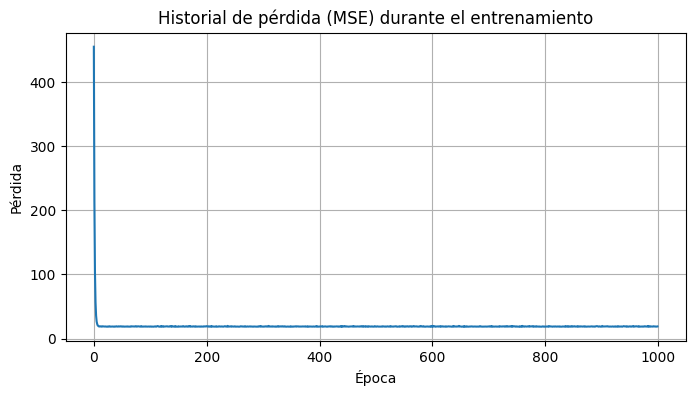

In [168]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

In [169]:
with torch.no_grad():
    pred = model(x_test_scaled.float())[:, 0]
    loss = loss_fn(pred, y_test_tensor)
    print(f"Test MSE: {loss.item():.4f}")
    print(f"Test MAE: {nn.L1Loss()(pred,y_test_tensor).item():.4f}")

Test MSE: 12.5959
Test MAE: 2.7095


In [170]:
x_plot = x_test_scaled[:, 0].numpy()
y_true = y_test_tensor.numpy()
y_pred = pred.numpy()

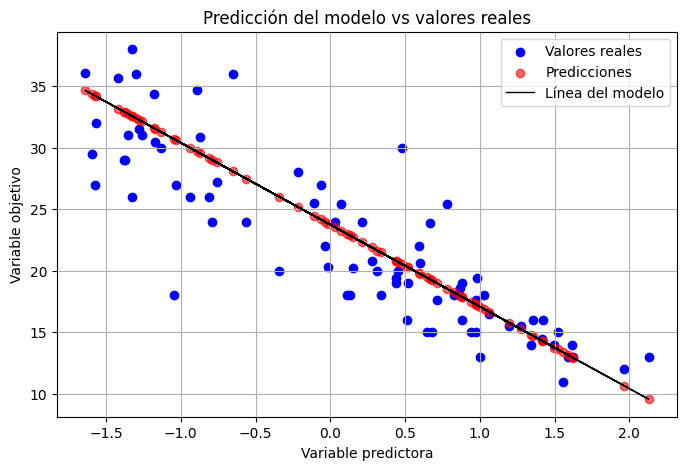

In [171]:
plt.figure(figsize=(8, 5))
plt.scatter(x_plot, y_true, color="blue", label="Valores reales")
plt.scatter(x_plot, y_pred, color="red", alpha=0.6, label="Predicciones")
plt.plot(x_plot, y_pred, color="black", linewidth=1, label="Línea del modelo")
plt.title("Predicción del modelo vs valores reales")
plt.xlabel("Variable predictora")
plt.ylabel("Variable objetivo")
plt.legend()
plt.grid(True)
plt.show()

### Punto 3

In [174]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nnx_test_scaled 
input_size = x_train.shape[1]
y_train_tensor = torch.tensor(y_train["MPG"].values).float()
y_test_tensor = torch.tensor(y_test["MPG"].values).float()

train_ds = TensorDataset(x_train_scaled, y_train_tensor)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


hidden_units = []
input_size = x_train.shape[1]

all_layers = []

all_layers.append(nn.Linear(input_size, 1))
all_layers.append(nn.ReLU())
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
)

Epoch 0 Loss 18.7784
Epoch 20 Loss 19.1520
Epoch 40 Loss 19.1849
Epoch 60 Loss 19.4926
Epoch 80 Loss 19.0227
Epoch 100 Loss 18.9375
Epoch 120 Loss 18.5525
Epoch 140 Loss 19.0367
Epoch 160 Loss 19.1364
Epoch 180 Loss 18.7953


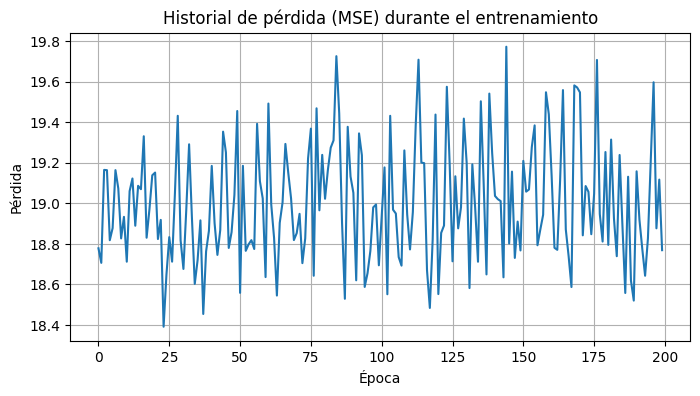

Test MSE: 12.3304
Test MAE: 2.6101


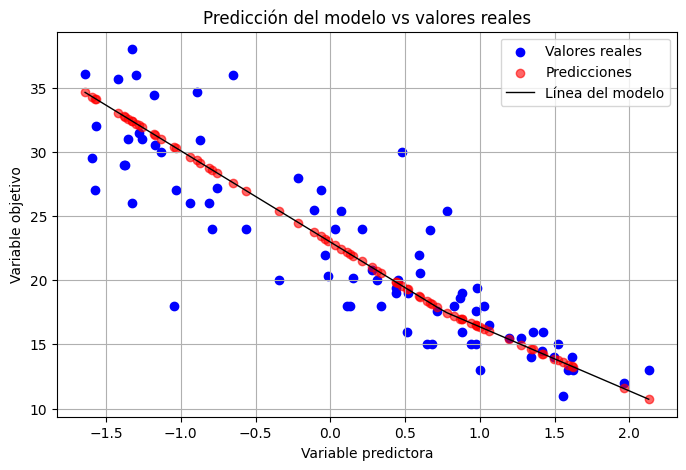

In [189]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
        
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():
    pred = model(x_test_scaled.float())[:, 0]
    loss = loss_fn(pred, y_test_tensor)
    print(f"Test MSE: {loss.item():.4f}")
    print(f"Test MAE: {nn.L1Loss()(pred,y_test_tensor).item():.4f}")
x_plot = x_test_scaled[:, 0].numpy()
y_true = y_test_tensor.numpy()
y_pred = pred.numpy()
sorted_indices = np.argsort(x_plot)
x_plot_sorted = x_plot[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]
plt.figure(figsize=(8, 5))
plt.scatter(x_plot, y_true, color="blue", label="Valores reales")
plt.scatter(x_plot, y_pred, color="red", alpha=0.6, label="Predicciones")
plt.plot(x_plot_sorted, y_pred_sorted, color="black", linewidth=1, label="Línea del modelo")
plt.title("Predicción del modelo vs valores reales")
plt.xlabel("Variable predictora")
plt.ylabel("Variable objetivo")
plt.legend()
plt.grid(True)
plt.show()

### Punto 4

In [179]:
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nn

train_ds = TensorDataset(x_train_scaled, y_train_tensor)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


hidden_units = [3, 1]
input_size = x_train.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=1, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=1, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1, out_features=1, bias=True)
)

In [180]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")

Epoch 0 Loss 561.0124
Epoch 20 Loss 19.2092
Epoch 40 Loss 19.2309
Epoch 60 Loss 19.5700
Epoch 80 Loss 19.0805
Epoch 100 Loss 18.9812
Epoch 120 Loss 18.5871
Epoch 140 Loss 19.0671
Epoch 160 Loss 19.1865
Epoch 180 Loss 18.8299


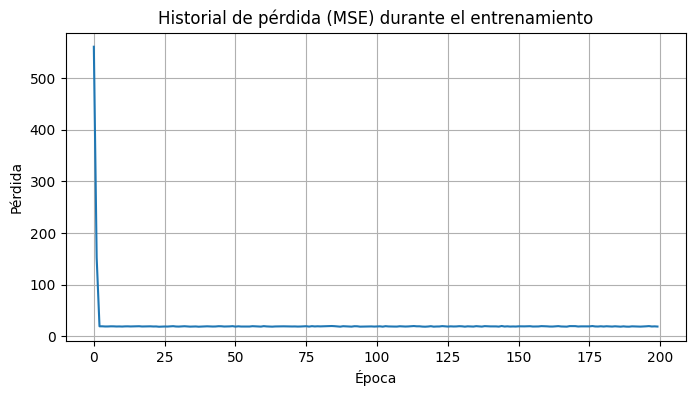

In [181]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

In [182]:
with torch.no_grad():
    pred = model(x_test_scaled.float())[:, 0]
    loss = loss_fn(pred, y_test_tensor)
    print(f"Test MSE: {loss.item():.4f}")
    print(f"Test MAE: {nn.L1Loss()(pred,y_test_tensor).item():.4f}")

Test MSE: 12.2851
Test MAE: 2.6095


In [183]:
x_plot = x_test_scaled[:, 0].numpy()
y_true = y_test_tensor.numpy()
y_pred = pred.numpy()

In [185]:
sorted_indices = np.argsort(x_plot)
x_plot_sorted = x_plot[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

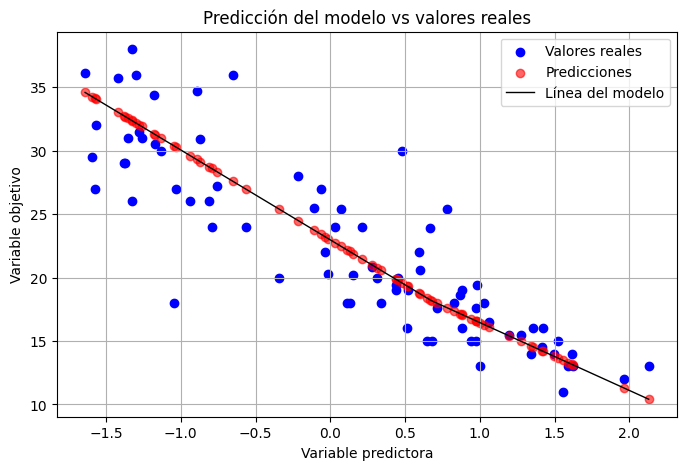

In [186]:
plt.figure(figsize=(8, 5))
plt.scatter(x_plot, y_true, color="blue", label="Valores reales")
plt.scatter(x_plot, y_pred, color="red", alpha=0.6, label="Predicciones")
plt.plot(x_plot_sorted, y_pred_sorted, color="black", linewidth=1, label="Línea del modelo")
plt.title("Predicción del modelo vs valores reales")
plt.xlabel("Variable predictora")
plt.ylabel("Variable objetivo")
plt.legend()
plt.grid(True)
plt.show()

# Parte 2 

In [40]:
path_hearth = (
    "/home/erich/dev/mastering_machine_learning/taller_clase_2/Erich/data/heart.csv"
)
df_hearth = pd.read_csv(path_hearth)

### Exploracion y limpieza

In [41]:
profile = ProfileReport(
    df_hearth,
    explorative=True,
    correlations={
        "auto": {"calculate": False},
        "pearson": {"calculate": True},
        "spearman": {"calculate": True},
        "kendall": {"calculate": True},
        "phi_k": {"calculate": True},
        "cramers": {"calculate": False},
    },
)

In [42]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 79244.61it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### age

<Axes: ylabel='age'>

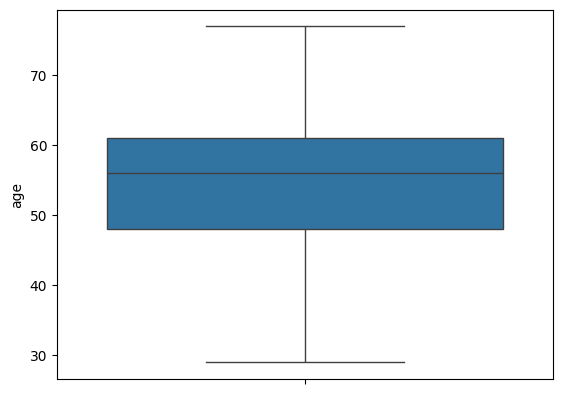

In [43]:
sns.boxplot(df_hearth["age"])

En general se observa una buena distribucion, no se realizaran cambios al menos en exploracion y limpieza

#### Sex

In [44]:
df_hearth["sex"].value_counts()

sex
1    205
0     98
Name: count, dtype: int64

Como se puede observar se tienen dos categorias y existe un desbalance notable, pero dado que este no es la variable objetivo no se va a hacer mayor cambio.

#### cp

In [45]:
df_hearth["cp"].value_counts()

cp
4    142
3     84
2     49
1     24
0      4
Name: count, dtype: int64

Dado que la clase 0 tiene solo 4 representantes y por ende esperamos que el modelo le cueste entender mas las caracteristicas, en casos generales juntariamos el caso 0 con el 1 pero en este caso cp en https://archive.ics.uci.edu/dataset/45/heart+disease esta definido como: 

cp: chest pain type
- Value 1: typical angina
- Value 2: atypical angina
- Value 3: non-anginal pain
- Value 4: asymptomatic

Por ende se va a considerara como un error y se va a eliminar

In [46]:
df_hearth = df_hearth[df_hearth["cp"] != 0]

In [47]:
df_hearth["cp"].value_counts()

cp
4    142
3     84
2     49
1     24
Name: count, dtype: int64

#### trestbps

<Axes: ylabel='trestbps'>

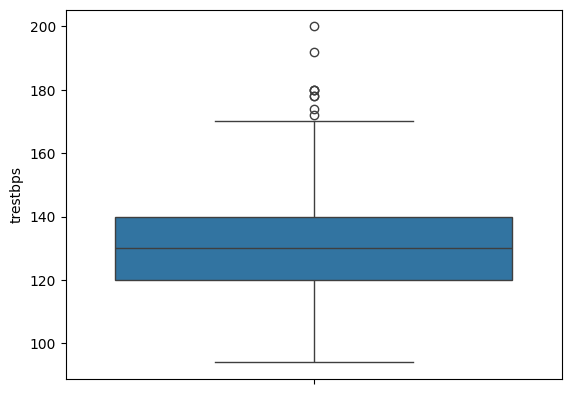

In [ ]:
sns.boxplot(df_hearth["trestbps"])

In [49]:
df_hearth["trestbps"].describe()

count    299.000000
mean     131.615385
std       17.747745
min       94.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: trestbps, dtype: float64

Teniendo en cuenta los resultados vamos a eliminar los datos que se pasen de el limite, por ende vamos a tener que eliminar los datos que se pasen de Q3 + 1.5 * IQR

In [ ]:
IQR = df_hearth["trestbps"].quantile(0.75) - df_hearth["trestbps"].quantile(0.25)

In [51]:
df_hearth["trestbps"].quantile(0.75) + 1.5 * IQR

np.float64(170.0)

In [52]:
df_hearth = df_hearth[df_hearth["trestbps"] <= 170]

<Axes: ylabel='trestbps'>

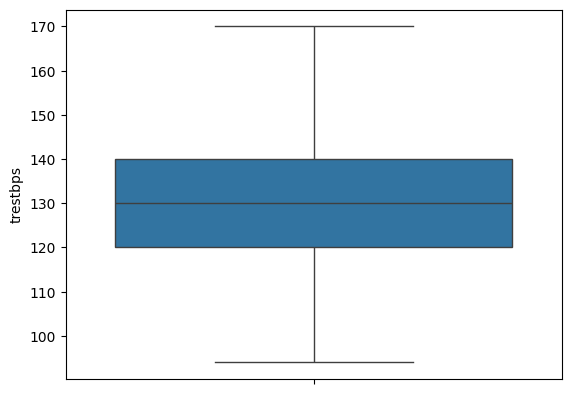

In [53]:
sns.boxplot(df_hearth["trestbps"])

#### chol

<Axes: ylabel='chol'>

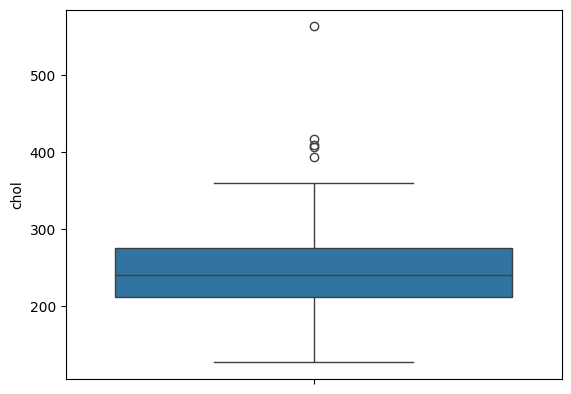

In [54]:
sns.boxplot(df_hearth["chol"])

In [ ]:
IQR = df_hearth["chol"].quantile(0.75) - df_hearth["chol"].quantile(0.25)
threashold = df_hearth["chol"].quantile(0.75) + 1.5 * IQR


df_hearth = df_hearth[df_hearth["chol"] <= threashold]

<Axes: ylabel='chol'>

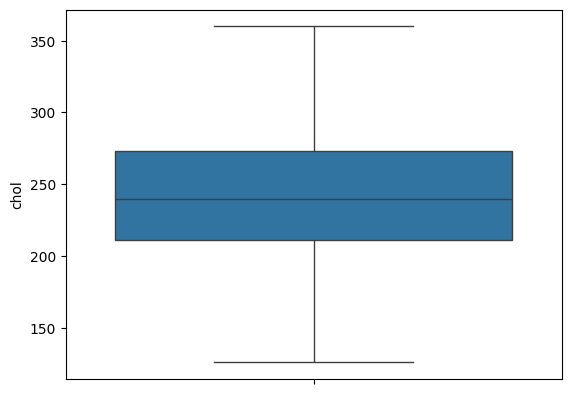

In [56]:
sns.boxplot(df_hearth["chol"])

#### restecg

In [57]:
df_hearth["restecg"].value_counts()

restecg
0    144
2    137
1      4
Name: count, dtype: int64

Teniendo en cuenta que solo hay 4 de la categoria 1 y este es having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), realmente el modelo de esa cantidad de casos no va a aprender mucho de la categoria, lo que termina haciendo que sea en su mayoria ruido. por ende se eliminaran los registros con esta categoria. 

In [ ]:
df_hearth = df_hearth[df_hearth["restecg"] != 1]

In [59]:
df_hearth["restecg"].value_counts()

restecg
0    144
2    137
Name: count, dtype: int64

#### thalach

<Axes: ylabel='thalach'>

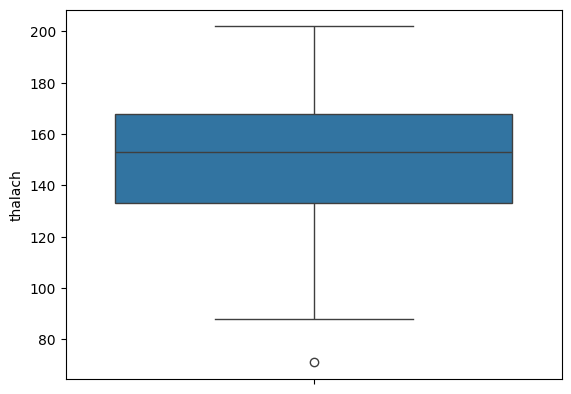

In [60]:
sns.boxplot(df_hearth["thalach"])

In [ ]:
IQR = df_hearth["thalach"].quantile(0.75) - df_hearth["thalach"].quantile(0.25)
threashold = df_hearth["thalach"].quantile(0.25) - 1.5 * IQR


df_hearth = df_hearth[df_hearth["thalach"] >= threashold]

<Axes: ylabel='thalach'>

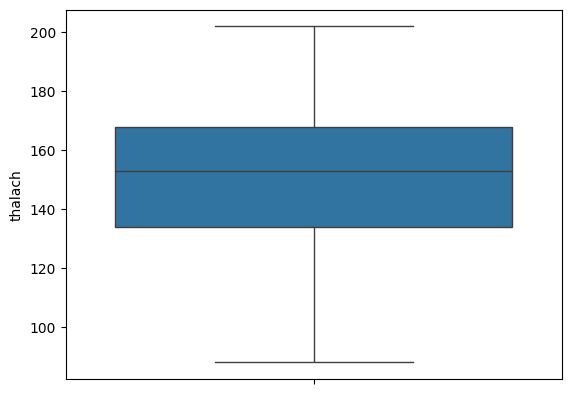

In [62]:
sns.boxplot(df_hearth["thalach"])

#### exang

In [63]:
df_hearth["exang"].value_counts()

exang
0    191
1     89
Name: count, dtype: int64

Hay desbalance pero no se va a hacer mucho

#### oldpeak

<Axes: ylabel='oldpeak'>

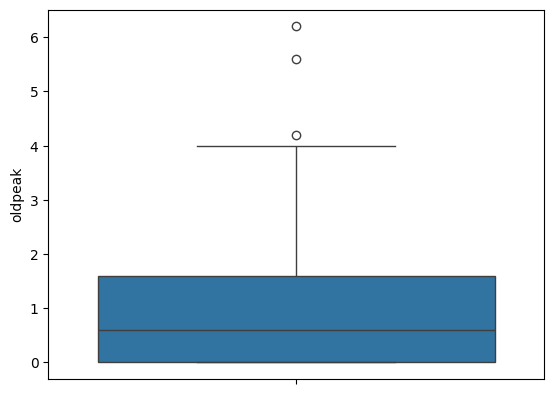

In [64]:
sns.boxplot(df_hearth["oldpeak"])

In [ ]:
IQR = df_hearth["oldpeak"].quantile(0.75) - df_hearth["oldpeak"].quantile(0.25)
threashold = df_hearth["oldpeak"].quantile(0.75) + 1.5 * IQR


df_hearth = df_hearth[df_hearth["oldpeak"] <= threashold]

<Axes: ylabel='oldpeak'>

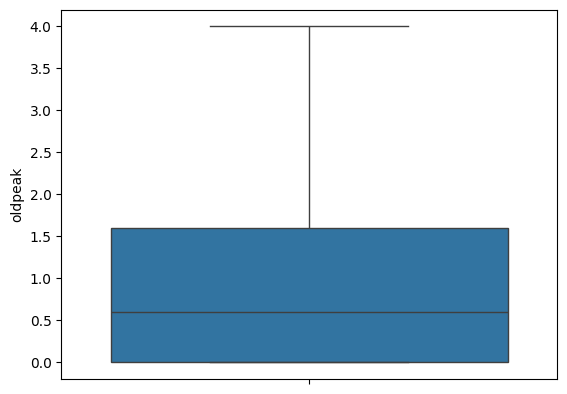

In [66]:
sns.boxplot(df_hearth["oldpeak"])

#### slope and ca

In [ ]:
df_hearth[
    "slope"
].value_counts()  # Aunque sea pequenio se va a dejar el 3, pero es perfectamente eliminable.

slope
1    136
2    125
3     16
Name: count, dtype: int64

In [ ]:
df_hearth["ca"].value_counts()

ca
0    163
1     63
2     35
3     16
Name: count, dtype: int64

#### thal

In [ ]:
df_hearth["thal"].value_counts()  # se elimina la clase que tiene un solo elemento

thal
normal        157
reversible    102
fixed          17
2               1
Name: count, dtype: int64

In [70]:
df_hearth = df_hearth[df_hearth["thal"] != "2"]

In [71]:
df_hearth["thal"].value_counts()

thal
normal        157
reversible    102
fixed          17
Name: count, dtype: int64

In [ ]:
thal_col = df_hearth[["thal"]]

encoder = OneHotEncoder(drop="first", sparse_output=False, dtype=int)

thal_encoded = encoder.fit_transform(thal_col)

thal_encoded_cols = encoder.get_feature_names_out(["thal"])

thal_encoded_df = pd.DataFrame(
    thal_encoded, columns=thal_encoded_cols, index=df_hearth.index
)

df_hearth = pd.concat([df_hearth.drop(columns="thal"), thal_encoded_df], axis=1)

#### target (variable a predecir)

In [73]:
df_hearth["target"].value_counts()

target
0    205
1     71
Name: count, dtype: int64

Como se puede ver se tiene un desbalance importante por ende tendremos que balancealas

In [ ]:
X = df_hearth.drop("target", axis=1)
y = df_hearth["target"]

smote = SMOTE(random_state=100)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled["target"] = y_resampled

In [ ]:
df_resampled["target"].value_counts()

target
0    205
1    205
Name: count, dtype: int64

In [78]:
df_resampled.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca  thal_normal  thal_reversible  target  
0   0            0                0       0  
1   3            1                0       1  
2   2            0                1       0  
3   0            1                0       0  
4   0            1                0       0

y asi tenemos las clases balanceadas y en general el dataset limpio

In [84]:
df_hearth = df_resampled

In [85]:
df_hearth

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang   oldpeak  \
0     63    1   1       145   233    1        2      150      0  2.300000   
1     67    1   4       160   286    0        2      108      1  1.500000   
2     67    1   4       120   229    0        2      129      1  2.600000   
3     37    1   3       130   250    0        0      187      0  3.500000   
4     41    0   2       130   204    0        2      172      0  1.400000   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...       ...   
405   64    1   3       108   290    0        2      115      0  1.123253   
406   61    1   4       122   259    0        0      138      0  3.481306   
407   63    1   3       162   279    0        1      118      0  1.901228   
408   47    1   4       124   173    0        2      121      1  2.805210   
409   63    0   4       148   214    0        2      134      0  2.126673   

     slope  ca  thal_normal  thal_reversible  target  
0        3   0            0                0       0  
1        2   3            1                0       1  
2        2   2            0                1       0  
3        3   0            1                0       0  
4        1   0            1                0       0  
..     ...  ..          ...              ...     ...  
405      2   1            0                0       1  
406      2   1            0                1       1  
407      2   2            0                1       1  
408      2   0            0                0       1  
409      2   2            0                0       1  

[410 rows x 15 columns]

### Mas tranformaciones

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numerical = ["age", "trestbps", "chol", "thalach", "oldpeak"]
binary = ["sex", "fbs", "restecg", "exang", "thal_normal", "thal_reversible"]
ordinal = ["slope", "ca", "cp"]

X = df_hearth.drop("target", axis=1)
y = df_hearth["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)



scaler_num = StandardScaler()
scaler_ord = MinMaxScaler()


X_train_num = pd.DataFrame(
    scaler_num.fit_transform(X_train[numerical]), columns=numerical, index=X_train.index
)
X_test_num = pd.DataFrame(
    scaler_num.transform(X_test[numerical]), columns=numerical, index=X_test.index
)

X_train_ord = pd.DataFrame(
    scaler_ord.fit_transform(X_train[ordinal]), columns=ordinal, index=X_train.index
)
X_test_ord = pd.DataFrame(
    scaler_ord.transform(X_test[ordinal]), columns=ordinal, index=X_test.index
)

X_train_bin = X_train[binary]
X_test_bin = X_test[binary]

X_train_processed = pd.concat([X_train_num, X_train_ord, X_train_bin], axis=1)


X_test_processed = pd.concat([X_test_num, X_test_ord, X_test_bin], axis=1)

X_train_processed = torch.tensor(X_train_processed.values).float()
X_test_processed = torch.tensor(X_test_processed.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

In [88]:
X_train_processed.shape

(328, 14)

### Punto 1 y 2

In [98]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)


hidden_units = [10, 5, 2]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=14, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=1, bias=True)
)

In [104]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")

Epoch 0 Loss 0.6647
Epoch 20 Loss 0.6489
Epoch 40 Loss 0.6393
Epoch 60 Loss 0.6265
Epoch 80 Loss 0.6151
Epoch 100 Loss 0.6028
Epoch 120 Loss 0.5909
Epoch 140 Loss 0.5761
Epoch 160 Loss 0.5589
Epoch 180 Loss 0.5459


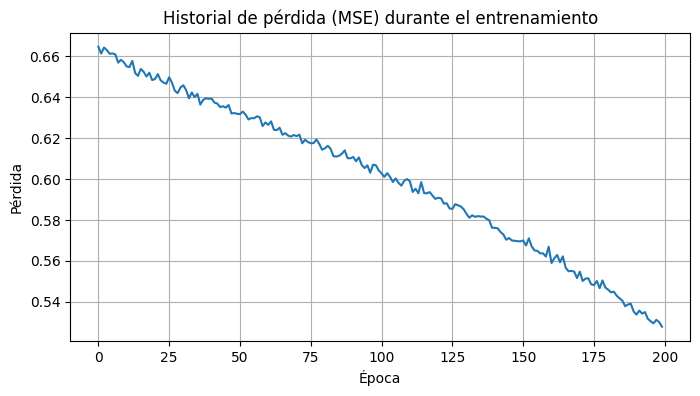

In [105]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()

In [ ]:
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")

Test Loss (BCEWithLogits): 0.5365
Test F1-Score: 0.7708
Test Accuracy: 0.7317


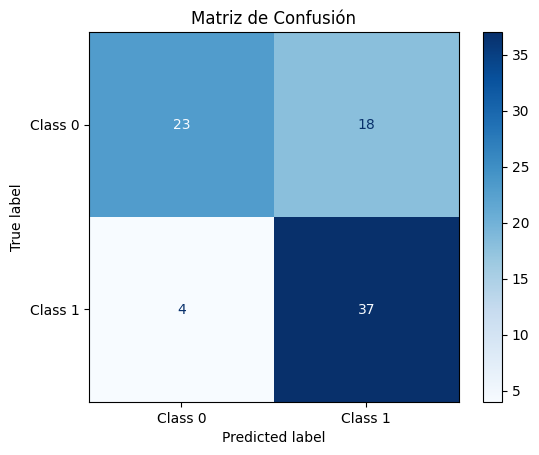

Matriz de Confusión:
 [[23 18]
 [ 4 37]]


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()

print("Matriz de Confusión:\n", cm)

### Punto 3 

##### Caso 2

Epoch 0 Loss 0.6932
Epoch 20 Loss 0.6930
Epoch 40 Loss 0.6930
Epoch 60 Loss 0.6928
Epoch 80 Loss 0.6926
Epoch 100 Loss 0.6926
Epoch 120 Loss 0.6923
Epoch 140 Loss 0.6922
Epoch 160 Loss 0.6920
Epoch 180 Loss 0.6919


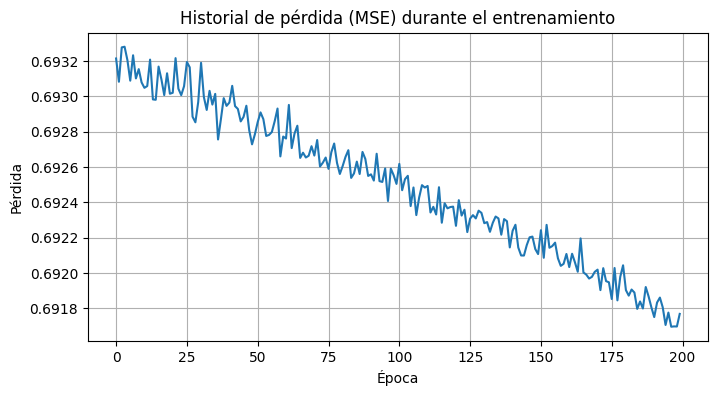

Test Loss (BCEWithLogits): 0.6915
Test F1-Score: 0.6833
Test Accuracy: 0.5366


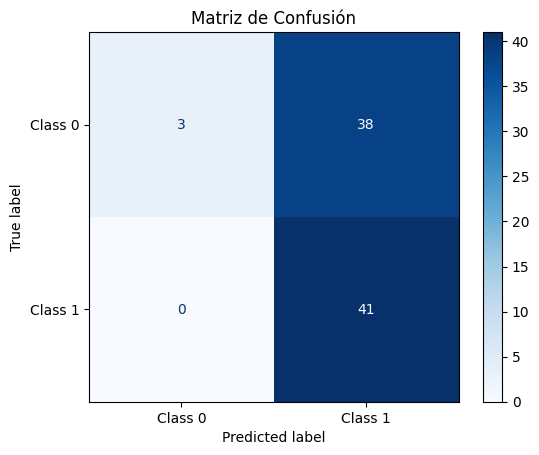

In [141]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)
hidden_units = [8, 5, 2]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()



##### Caso 2

Epoch 0 Loss 0.7251
Epoch 20 Loss 0.7176
Epoch 40 Loss 0.7092
Epoch 60 Loss 0.7059
Epoch 80 Loss 0.7032
Epoch 100 Loss 0.6986
Epoch 120 Loss 0.6993
Epoch 140 Loss 0.6961
Epoch 160 Loss 0.6955
Epoch 180 Loss 0.6949


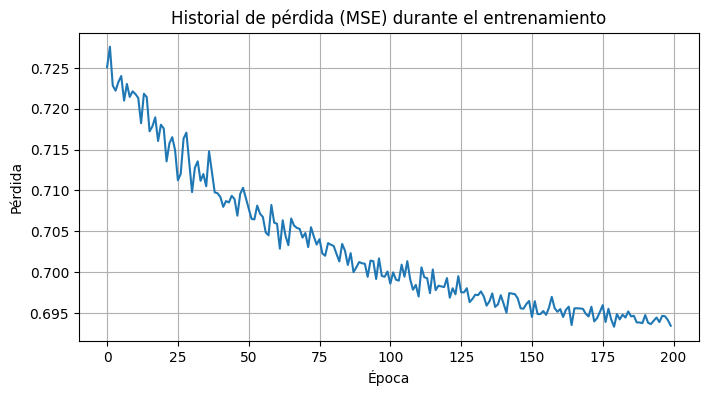

Test Loss (BCEWithLogits): 0.6936
Test F1-Score: 0.0000
Test Accuracy: 0.5000


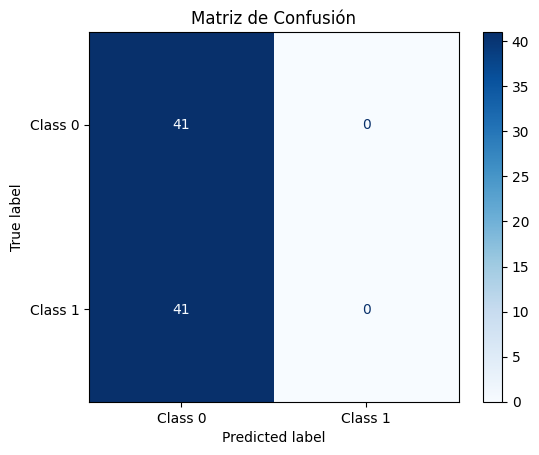

In [142]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [12, 4, 2]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()


### Punto 4

##### Caso 1

Epoch 0 Loss 0.6927
Epoch 20 Loss 0.6898
Epoch 40 Loss 0.6875
Epoch 60 Loss 0.6843
Epoch 80 Loss 0.6807
Epoch 100 Loss 0.6776
Epoch 120 Loss 0.6727
Epoch 140 Loss 0.6679
Epoch 160 Loss 0.6617
Epoch 180 Loss 0.6558


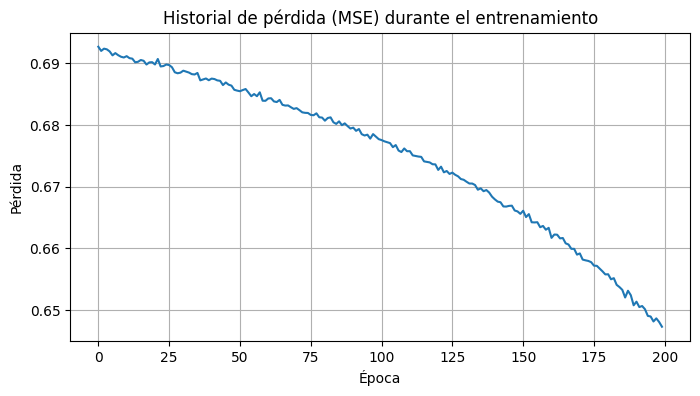

Test Loss (BCEWithLogits): 0.6507
Test F1-Score: 0.8000
Test Accuracy: 0.7683


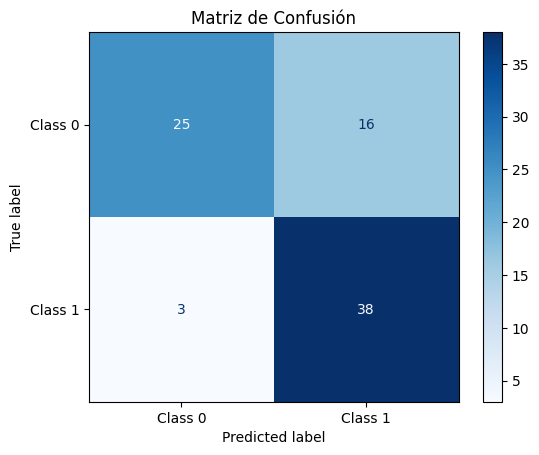

In [143]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [10, 5]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()


##### Caso 2

Epoch 0 Loss 0.6991
Epoch 20 Loss 0.6930
Epoch 40 Loss 0.6887
Epoch 60 Loss 0.6819
Epoch 80 Loss 0.6763
Epoch 100 Loss 0.6704
Epoch 120 Loss 0.6638
Epoch 140 Loss 0.6569
Epoch 160 Loss 0.6486
Epoch 180 Loss 0.6416


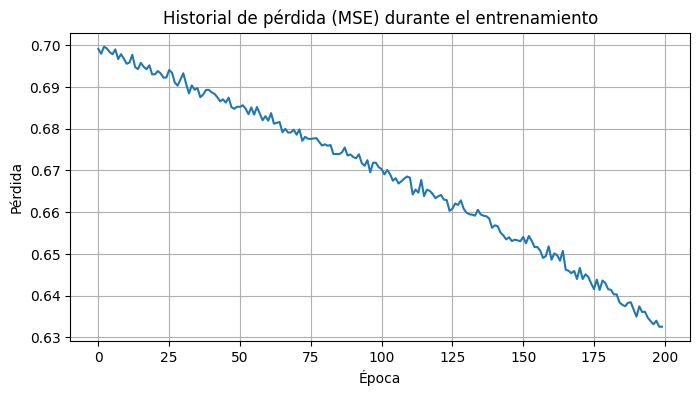

Test Loss (BCEWithLogits): 0.6332
Test F1-Score: 0.7358
Test Accuracy: 0.6585


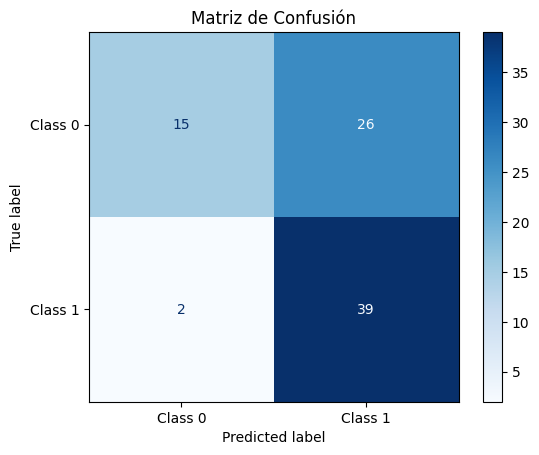

In [144]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [10]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()

#### Punto 5

##### Caso 1

Epoch 0 Loss 0.7117
Epoch 20 Loss 0.7064
Epoch 40 Loss 0.6998
Epoch 60 Loss 0.6968
Epoch 80 Loss 0.6944
Epoch 100 Loss 0.6901
Epoch 120 Loss 0.6902
Epoch 140 Loss 0.6871
Epoch 160 Loss 0.6857
Epoch 180 Loss 0.6842


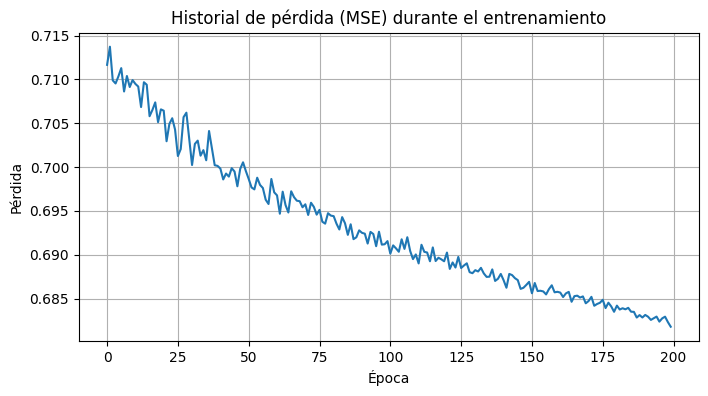

Test Loss (BCEWithLogits): 0.6827
Test F1-Score: 0.5846
Test Accuracy: 0.6707


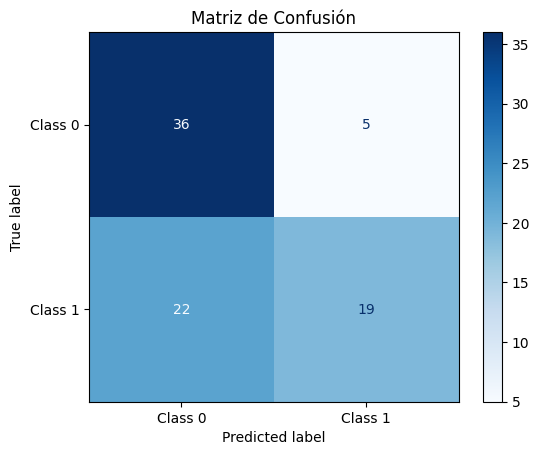

In [145]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [10,5,2]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.LeakyReLU())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()

##### Caso 2

Epoch 0 Loss 0.7000
Epoch 20 Loss 0.6957
Epoch 40 Loss 0.6905
Epoch 60 Loss 0.6863
Epoch 80 Loss 0.6817
Epoch 100 Loss 0.6757
Epoch 120 Loss 0.6716
Epoch 140 Loss 0.6641
Epoch 160 Loss 0.6559
Epoch 180 Loss 0.6469


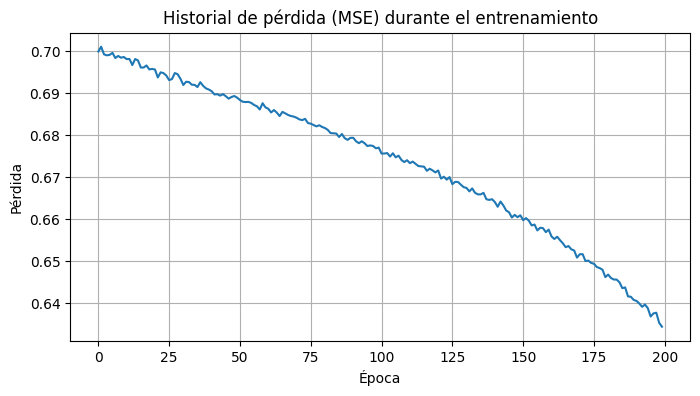

Test Loss (BCEWithLogits): 0.6471
Test F1-Score: 0.7013
Test Accuracy: 0.7195


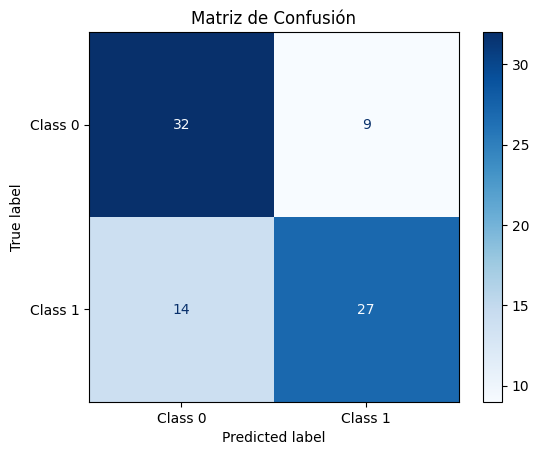

In [146]:
train_ds = TensorDataset(X_train_processed, y_train)
batch_size = 16
torch.manual_seed(77)

train_dl = DataLoader(train_ds, batch_size, shuffle=True)

hidden_units = [10,5,2]
input_size = X_train_processed.shape[1]

all_layers = []
for hidden_units_layer in hidden_units:
    layer = nn.Linear(input_size, hidden_units_layer)
    all_layers.append(layer)
    all_layers.append(nn.Tanh())
    input_size = hidden_units_layer

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

torch.manual_seed(1)
num_epochs = 200
log_epochs = 20
loss_history = []

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()

    avg_loss = loss_hist_train / len(train_dl)
    loss_history.append(avg_loss)
    if epoch % log_epochs == 0:
        print(f"Epoch {epoch} Loss {avg_loss:.4f}")
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.title("Historial de pérdida (MSE) durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.grid(True)
plt.show()
with torch.no_grad():

    pred_logits = model(X_test_processed.float())[:, 0]

    loss = loss_fn(pred_logits, y_test)
    probabilities = torch.sigmoid(pred_logits)

    predicted_classes = (probabilities > 0.5).long()

    true_classes = y_test.long()

    print(f"Test Loss (BCEWithLogits): {loss.item():.4f}")

    f1 = f1_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy(), average='binary')
    print(f"Test F1-Score: {f1:.4f}")


    accuracy = accuracy_score(true_classes.cpu().numpy(), predicted_classes.cpu().numpy())
    print(f"Test Accuracy: {accuracy:.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true_np = y_test.detach().cpu().numpy()
y_pred_np = predicted_classes.detach().cpu().numpy()

cm = confusion_matrix(y_true_np, y_pred_np)

class_labels = ['Class 0', 'Class 1'] 

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues) 
plt.title("Matriz de Confusión")
plt.show()